In [1]:
!conda activate DS807

## Preparation of data

### Labeling Data and converting images to array values

In [2]:
#import packages for labelling and converting imagery data
import pandas as pd
import numpy as np
import os
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import asarray

In [3]:
##############
# Func for creating 1D image arrays

def load_image_function(path):
    images = [] # empty list placeholder
    labels = [] # empty list placeholder
    container = [] # container to validate correct labels
    for filename in os.listdir(path):
        container.append(filename) # add filename to container     
        CCDY_img = load_img(path + f'/{filename}', target_size = (56, 106),
        color_mode="grayscale")                  
        CCDY_img = img_to_array(CCDY_img)
        images.append(CCDY_img) # append the photo to the images. The images list contains a list of arrays       
    return asarray(images), container; # not interested in list of arrays, but array containing lists. Asarray does this. Returns three arrays


In [4]:
################
# Func for creating df with classes and 3d img arrays

def load_img_data ():
    # Start: creatign classes ons string_digits
    # load string digits

    #os.chdir(path_string_digits)

    string_digits = pd.read_csv('DIDA_12000_String_Digit_Labels.csv', 
                 header = None, 
                 names=["index", "string"])
    # create empty class columns
    string_digits['CC'] = 0
    string_digits['D'] = 0
    string_digits['Y'] = 0
    string_digits = string_digits.astype(str)
    # Iterate string digits and append classes
    for i, row in string_digits.iterrows():
        if len(row['string']) != 4:
            row['CC'] = '1'
            row['D'] = '10'
            row['Y'] = '10'
        else:
            row['D'] = row['string'][2]
            row['Y'] = row['string'][3]
            if row['string'][0:2] == '18':
                row['CC']='0'
            else:
                row['CC']='1'
    # End of class labeling on string_digits.
    #
    # Start: create img_df containing scaled images as 1D tensors
    # Convert imagery to 1D arrays with tagged file names

    #os.chdir(path_images)
    image_array, filename = load_image_function('DIDA_12000_String_Digit_Images/DIDA_1')

    # and convert to a img_df
    img_df = pd.DataFrame({'filename': filename, 'img_value': list(image_array)}, 
                          columns=['filename', 'img_value'])
    # Create proper index value in img_df to allow merge on string_digits
    img_df['index'] = img_df['filename']
    for i, row in img_df.iterrows():
        row['index'] = str(img_df['index'][i]).split('.')[0]
    img_df
    # End of creating img_df
    #
    # Start: merge img_df with string_digits
    # match index type on dataframes to merge
    string_digits['index'] = string_digits['index'].astype(int)
    img_df['index'] = img_df['index'].astype(int)
    # Merge dataframes
    df_img_classes = string_digits.merge(img_df)
    # Rearrange order of dataframe
    df_img_classes = df_img_classes.reindex(columns= ['index', 'string', 'CC', 'D', 'Y', 'img_value', 'filename'])
    # End og merging data frames
    return df_img_classes


In [5]:
#load data and shuffle them around
df = load_img_data()
df = df.sample(frac=1).reset_index(drop=True)
df

,index,string,CC,D,Y,img_value,filename
0,2438,1818,0,1,8,"[[[124.0], [125.0], [121.0], [124.0], [120.0],...",2438.jpg
1,6981,72,1,10,10,"[[[184.0], [185.0], [186.0], [184.0], [184.0],...",6981.jpg
2,8007,1833,0,3,3,"[[[162.0], [169.0], [170.0], [168.0], [172.0],...",8007.jpg
3,142,1806,0,0,6,"[[[132.0], [113.0], [154.0], [149.0], [153.0],...",142.jpg
4,481,1813,0,1,3,"[[[129.0], [130.0], [131.0], [132.0], [132.0],...",481.jpg
...,...,...,...,...,...,...,...
11995,3482,1819,0,1,9,"[[[114.0], [114.0], [114.0], [113.0], [111.0],...",3482.jpg
11996,3904,1803,0,0,3,"[[[137.0], [137.0], [137.0], [139.0], [140.0],...",3904.jpg
11997,8564,1820,0,2,0,"[[[167.0], [167.0], [167.0], [167.0], [167.0],...",8564.jpg
11998,5139,1812,0,1,2,"[[[167.0], [169.0], [167.0], [168.0], [168.0],...",5139.jpg


### Defining fixed train, test and valdiation sets.

In [6]:
df = df.drop(columns=['index','string','filename'])

### Split train, val, test

#### Subsetting df

In [7]:
x_train = df.loc[0:7679]
x_val = df.loc[7680:9599]
x_test = df.loc[9600:11999]

#### Creating labels

In [8]:
#### training labels ###
Y_train = x_train['Y']
Y_train = Y_train.astype(np.uint8)
D_train = x_train['D']
D_train = D_train.astype(np.uint8)
CC_train = x_train['CC']
CC_train = CC_train.astype(np.uint8)

#### validation labels ###
Y_val = x_val['Y']
Y_val = Y_val.astype(np.uint8)
D_val = x_val['D']
D_val = D_val.astype(np.uint8)
CC_val = x_val['CC']
CC_val = CC_val.astype(np.uint8)

#### test labels ###
Y_test = x_test['Y']
Y_test = Y_test.astype(np.uint8)
D_test = x_test['D']
D_test = D_test.astype(np.uint8)
CC_test = x_test['CC']
CC_test = CC_test.astype(np.uint8)


#### Creating image values

In [9]:
# train
values = np.zeros(shape=(len(x_train),56,106,1))
i = 0
j = 0
while i < len(x_train):
    values[i] = x_train['img_value'][j]
    i += 1
    j+=1
x_train = values/255

# val
values = np.zeros(shape=(len(x_val),56,106,1))
i = 0
j = 7680
while i < len(x_val):
    values[i] = x_val['img_value'][j]
    i += 1
    j+=1
x_val = values/255

# test
values = np.zeros(shape=(len(x_test),56,106,1))
i = 0
j = 9600
while i < len(x_test):
    values[i] = x_test['img_value'][j]
    i += 1
    j+=1
x_test = values/255


## Question 2.2.B, Optimizations, hyperparameter search

Importing packages:

In [10]:
import tensorflow as tf
import data_loader as dl
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt


Defining a function for plotting model history:

In [11]:
def plots (history, label):
    fig = plt.figure(figsize=plt.figaspect(0.3))

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history['loss'], label='Training loss')
    ax.plot(history.history['val_loss'], label='Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss, '+label)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history['accuracy'], label='Training accuracy')
    ax.plot(history.history['val_accuracy'], label='Val accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy, '+label)

    plt.show()

### **Model CC**

#### Batch normalization

##### **-2 first layers**

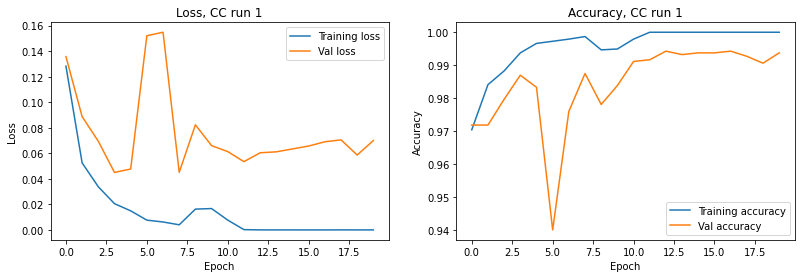

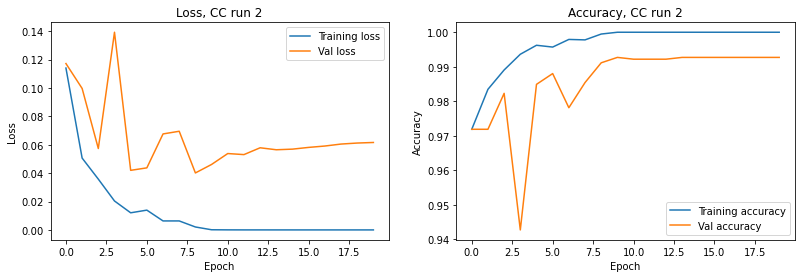

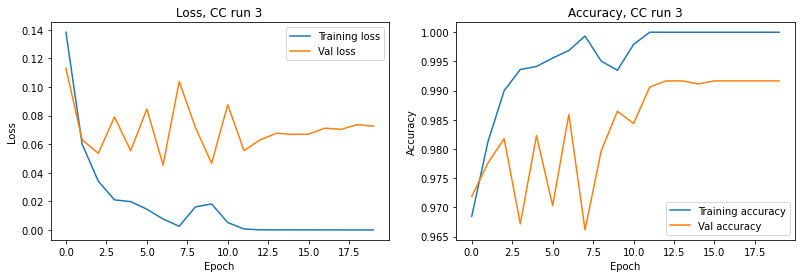

In [28]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

    model.compile(
        optimizer='adam',
        loss= 'binary_crossentropy',
        metrics=['accuracy'],
        ) 

    history = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
    plots(history,'CC run '+str(i))
    i += 1

##### **-2 last layers**

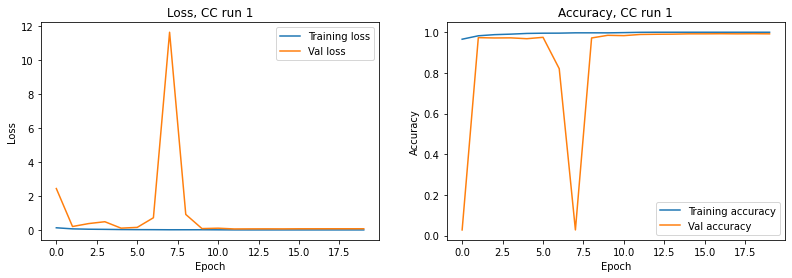

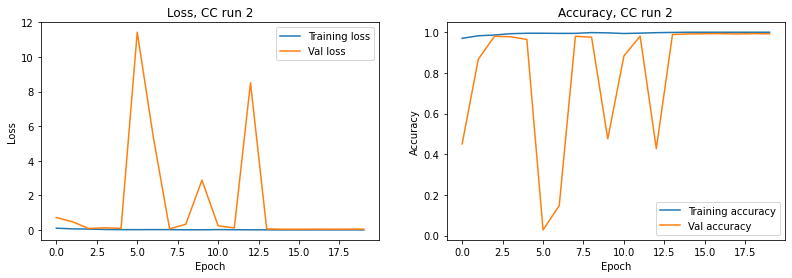

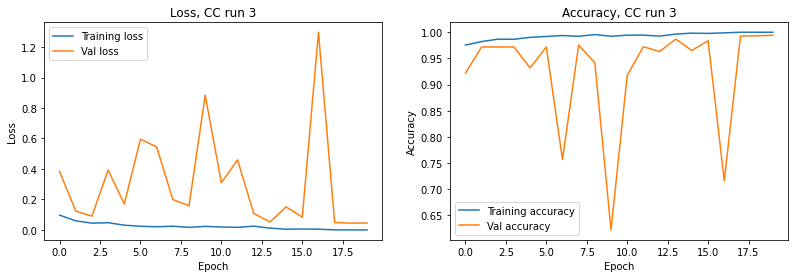

In [29]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

    model.compile(
        optimizer='adam',
        loss= 'binary_crossentropy',
        metrics=['accuracy'],
        ) 

    history = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
    plots(history,'CC run '+str(i))
    i += 1

##### **-all 4 layers**

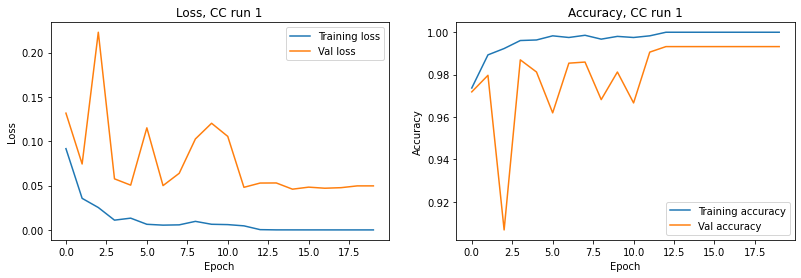

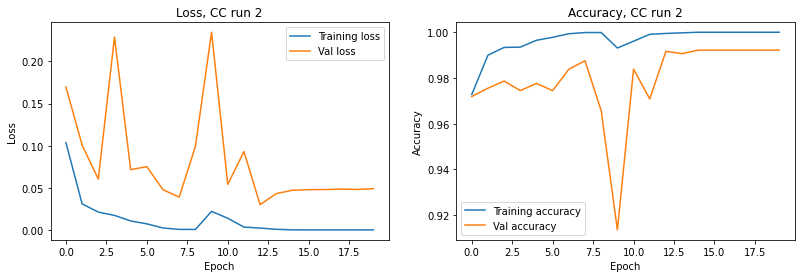

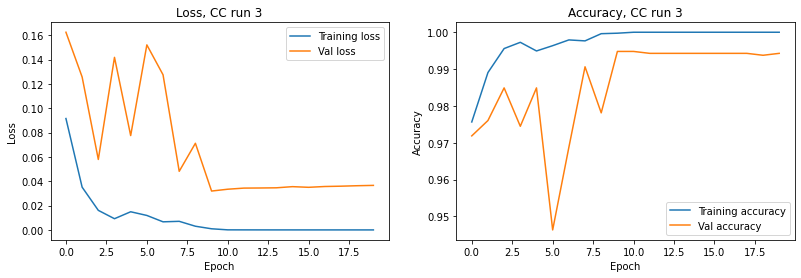

In [30]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

    model.compile(
        optimizer='adam',
        loss= 'binary_crossentropy',
        metrics=['accuracy'],
        ) 

    history = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
    plots(history,'CC run '+str(i))
    i += 1

#### Learning rates

##### **0.001**

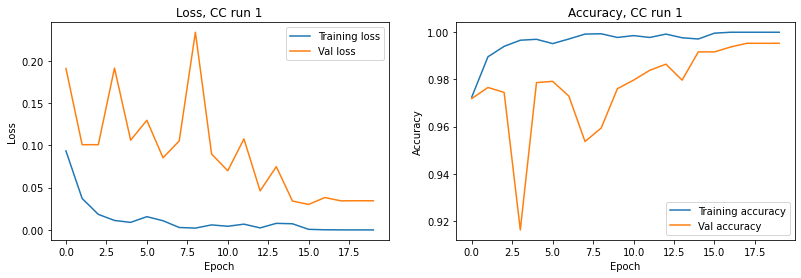

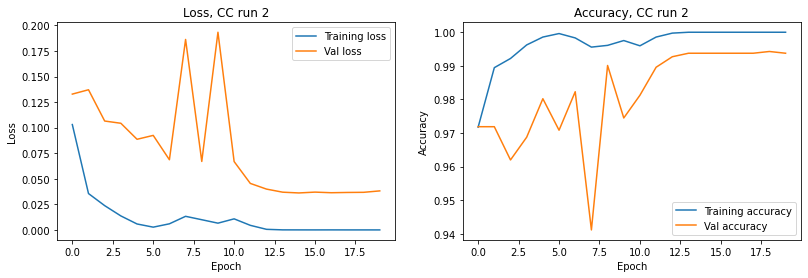

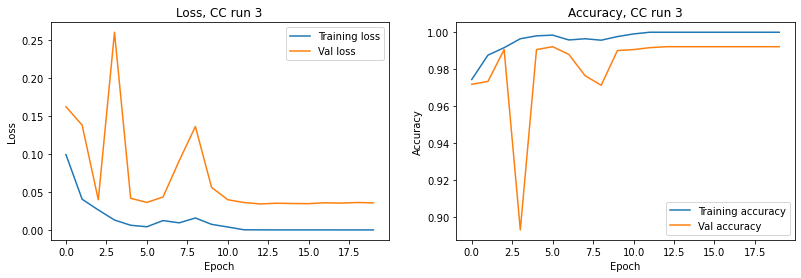

In [31]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
        loss= 'binary_crossentropy',
        metrics=['accuracy'],
        ) 

    history = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
    plots(history,'CC run '+str(i))
    i += 1

##### **0.0008**

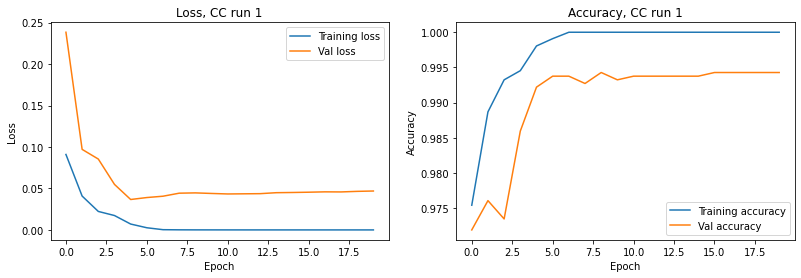

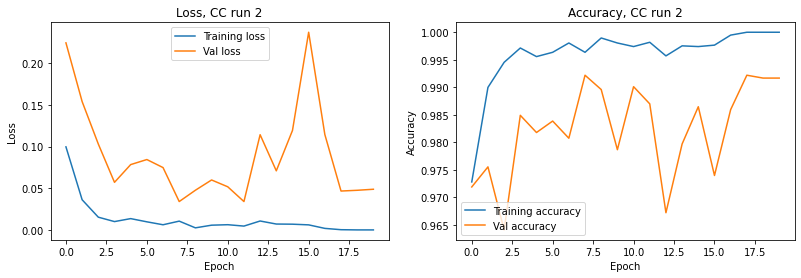

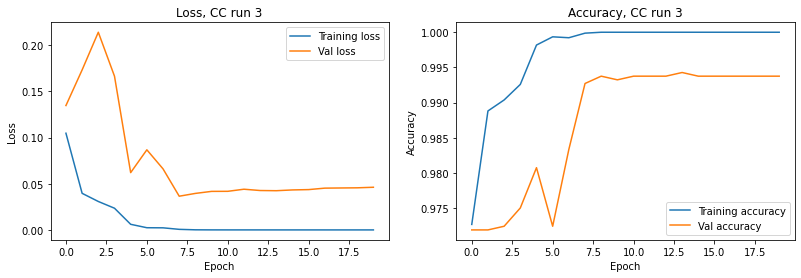

In [32]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
        loss= 'binary_crossentropy',
        metrics=['accuracy'],
        ) 

    history = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
    plots(history,'CC run '+str(i))
    i += 1

##### **0.0005**

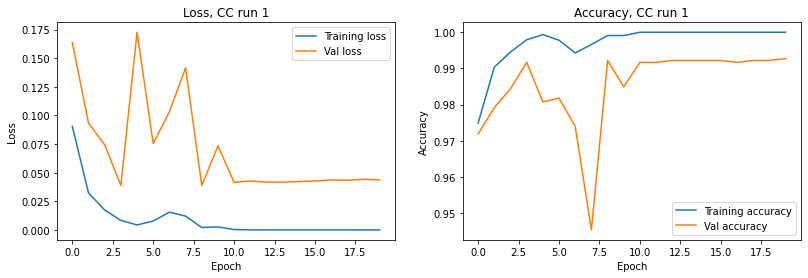

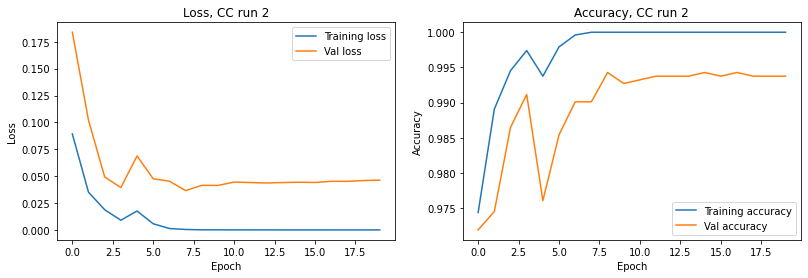

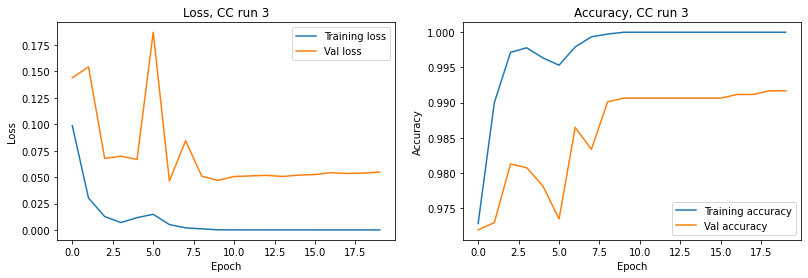

In [33]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
        loss= 'binary_crossentropy',
        metrics=['accuracy'],
        ) 

    history = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
    plots(history,'CC run '+str(i))
    i += 1

#### Dropout 0.5

##### **First 2 layers**

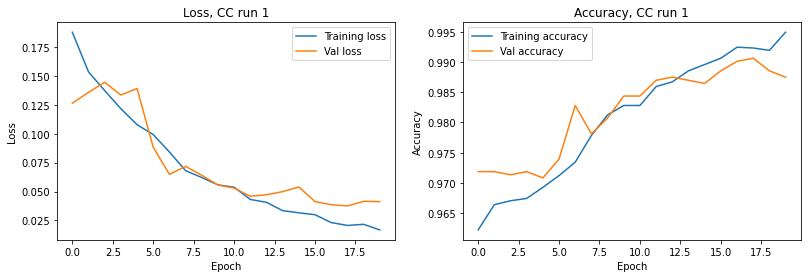

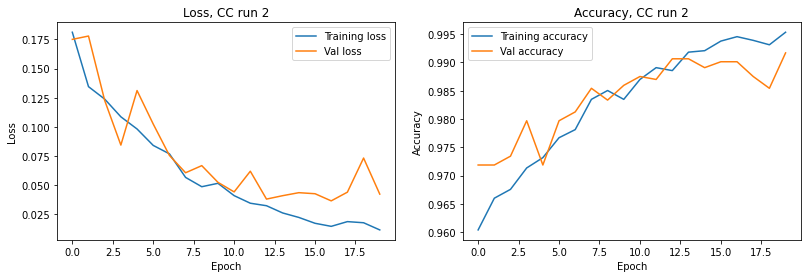

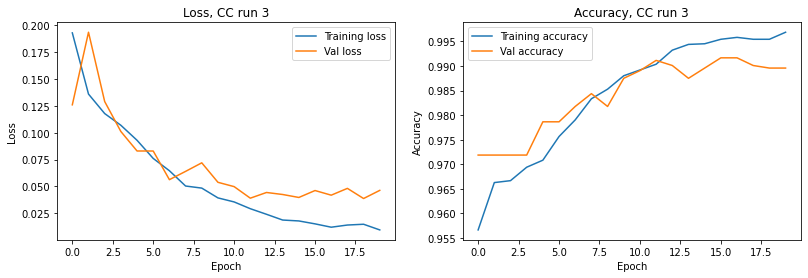

In [48]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
        loss= 'binary_crossentropy',
        metrics=['accuracy'],
        ) 

    history = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
    plots(history,'CC run '+str(i))
    i += 1

##### **Last 2 layers**

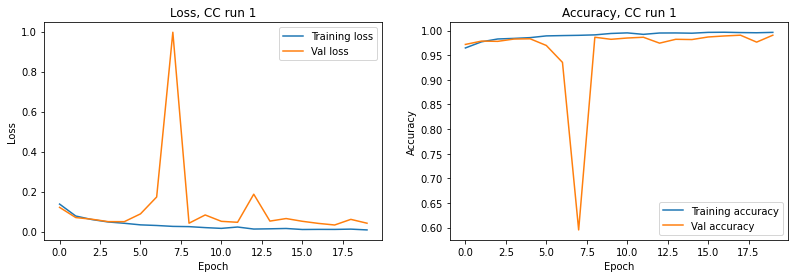

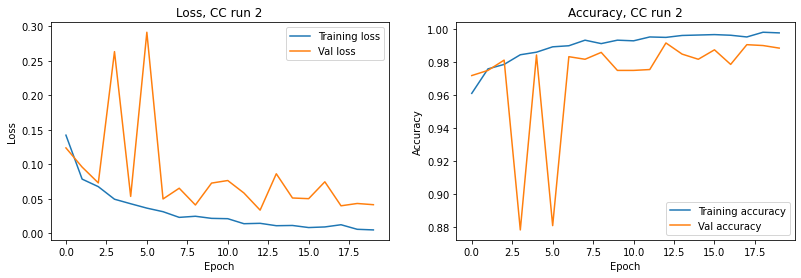

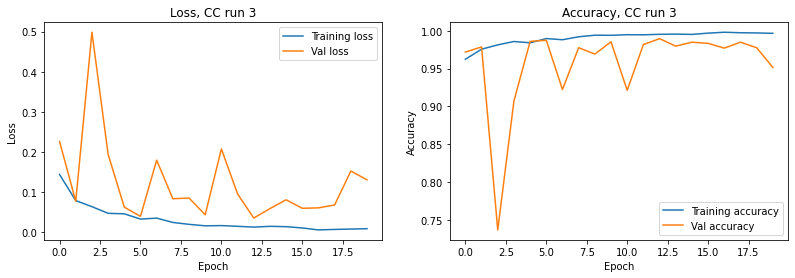

In [47]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
        loss= 'binary_crossentropy',
        metrics=['accuracy'],
        ) 

    history = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
    plots(history,'CC run '+str(i))
    i += 1

##### **All layers**

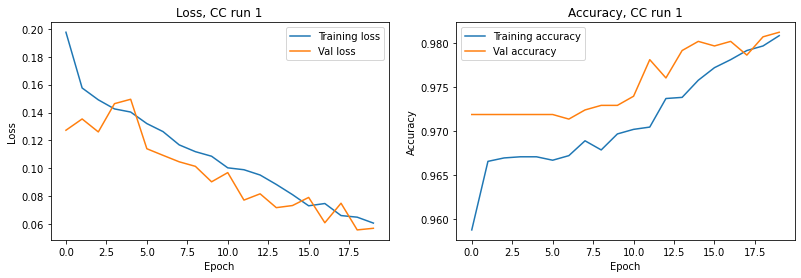

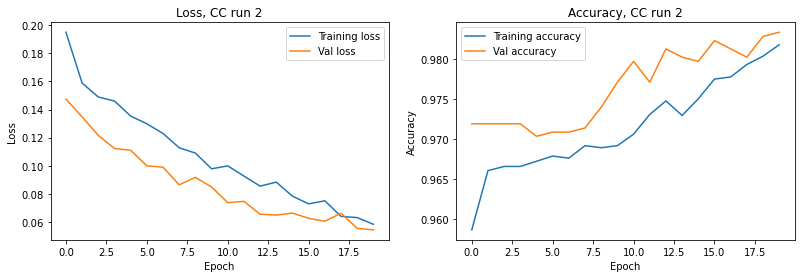

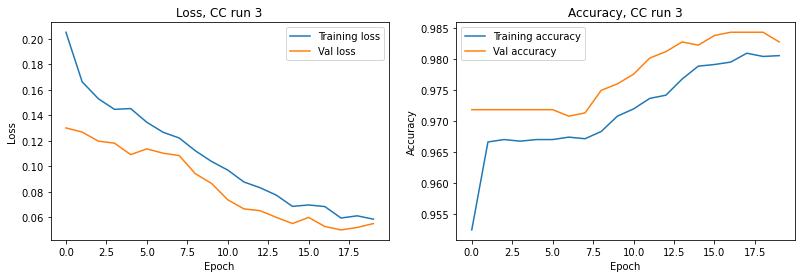

In [46]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
        loss= 'binary_crossentropy',
        metrics=['accuracy'],
        ) 

    history = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
    plots(history,'CC run '+str(i))
    i += 1

#### Earlystopping on optimized model

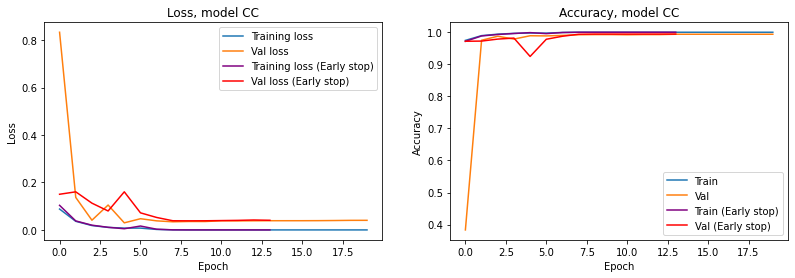

In [69]:
 ### with early stop
model = tf.keras.models.Sequential([
        
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

model.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
loss= 'binary_crossentropy',
metrics=['accuracy'],
) 

history_stop = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))

  
#### Without early stop

model = tf.keras.models.Sequential([
        
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
    loss= 'binary_crossentropy',
    metrics=['accuracy'],
    ) 

history = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)

########
### Plot with and without early stop
########

fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label='Training loss')
ax.plot(history.history['val_loss'], label = 'Val loss')
ax.plot(history_stop.history['loss'], 'purple', label = 'Training loss (Early stop)')
ax.plot(history_stop.history['val_loss'], 'red', label = 'Val loss (Early stop)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, model CC')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['accuracy'], label='Train')
ax.plot(history.history['val_accuracy'], label = 'Val')
ax.plot(history_stop.history['accuracy'], 'purple', label = 'Train (Early stop)')
ax.plot(history_stop.history['val_accuracy'], 'red', label = 'Val (Early stop)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, model CC')

plt.show()

#### Performance on test data

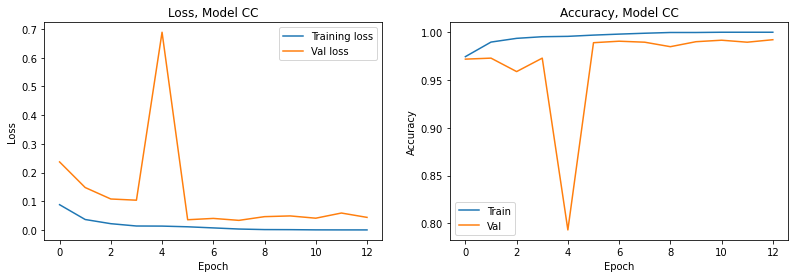

In [88]:
 ### with early stop
model = tf.keras.models.Sequential([
        
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

model.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
loss= 'binary_crossentropy',
metrics=['accuracy'],
) 

history = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=60, verbose=0,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))

fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label='Training loss')
ax.plot(history.history['val_loss'], label = 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, Model CC')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['accuracy'], label='Train')
ax.plot(history.history['val_accuracy'], label = 'Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, Model CC')

plt.show()


In [91]:
model.evaluate(x_test, CC_test, batch_size = len(CC_test))

1/1 [==============================] - 1s 1s/step - loss: 0.0385 - accuracy: 0.9933


[0.03854484483599663, 0.9933333396911621]

### **ModelY**

#### Batch normalization

##### **-2 first layers**

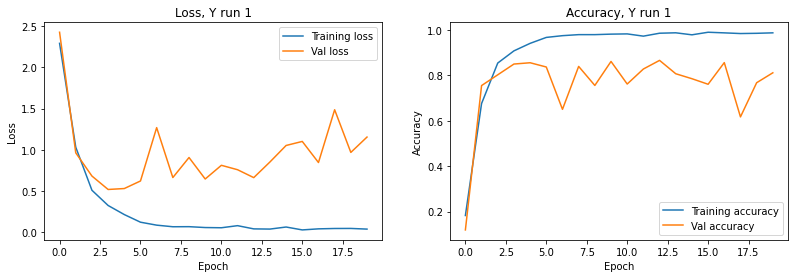

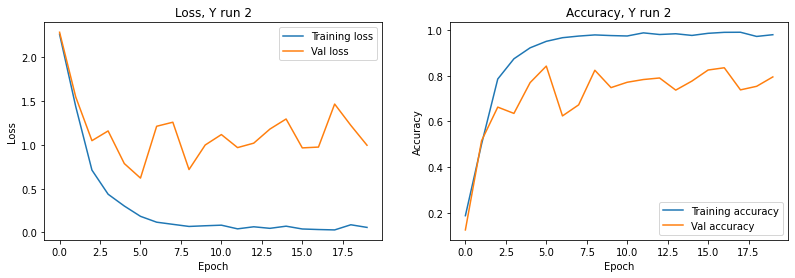

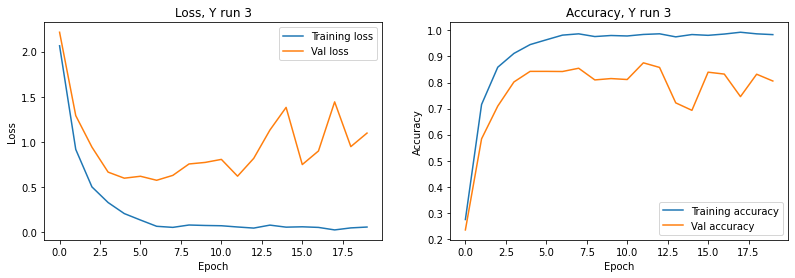

In [18]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer='adam',
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 

    history = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
    plots(history,'Y run '+str(i))
    i += 1

##### **-2 last layers**

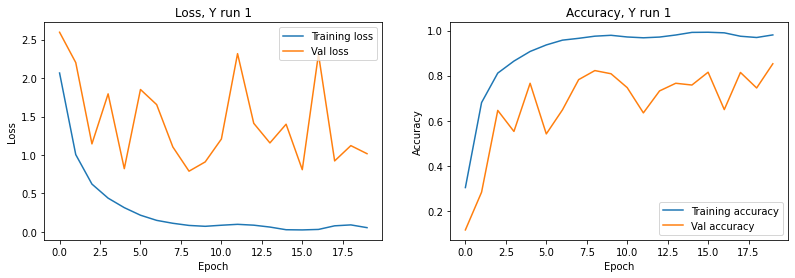

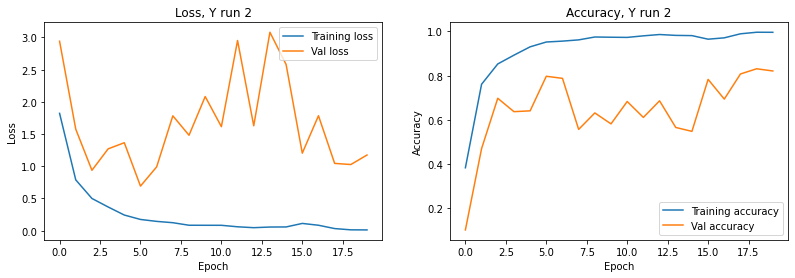

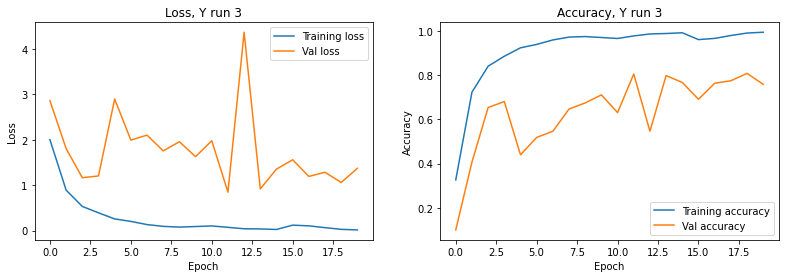

In [20]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer='adam',
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 

    history = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
    plots(history,'Y run '+str(i))
    i += 1

##### **-all 4 layers**

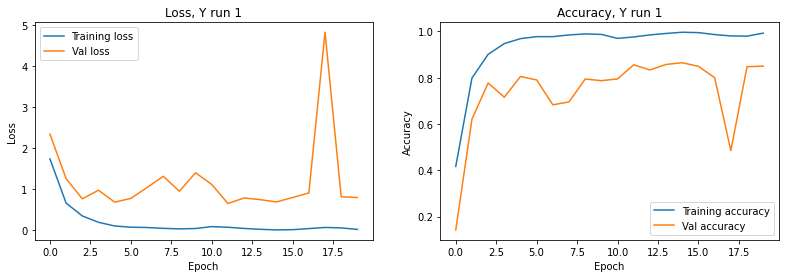

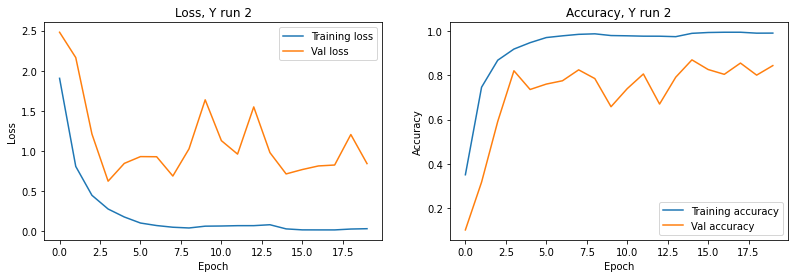

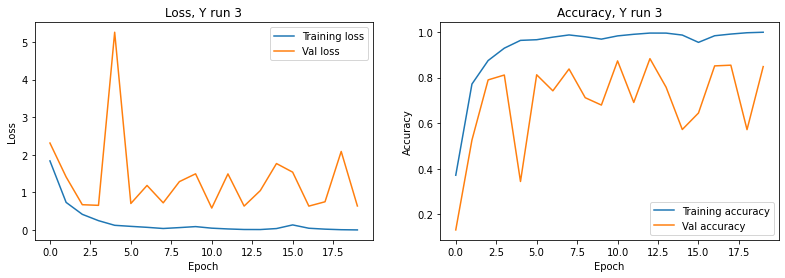

In [21]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer='adam',
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 


    history = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
    plots(history,'Y run '+str(i))
    i += 1

#### Learning rates

##### **0.001**

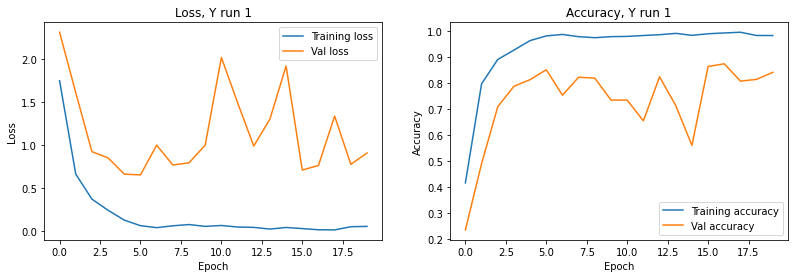

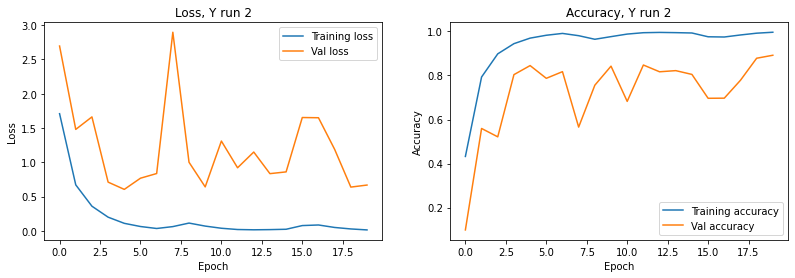

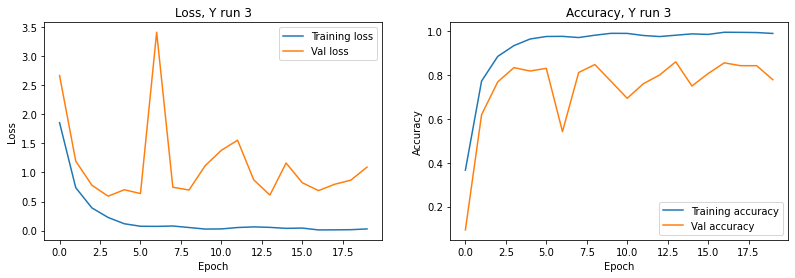

In [34]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 


    history = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
    plots(history,'Y run '+str(i))
    i += 1

##### **0.0008**

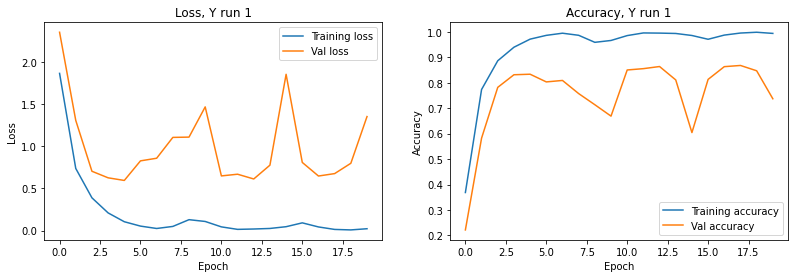

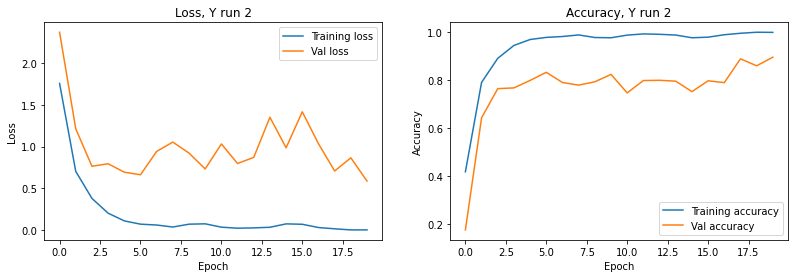

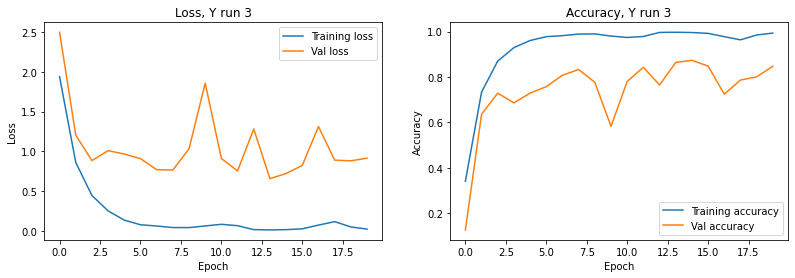

In [35]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 


    history = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
    plots(history,'Y run '+str(i))
    i += 1

##### **0.0005**

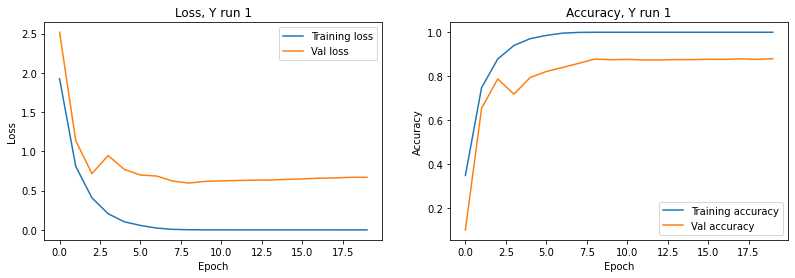

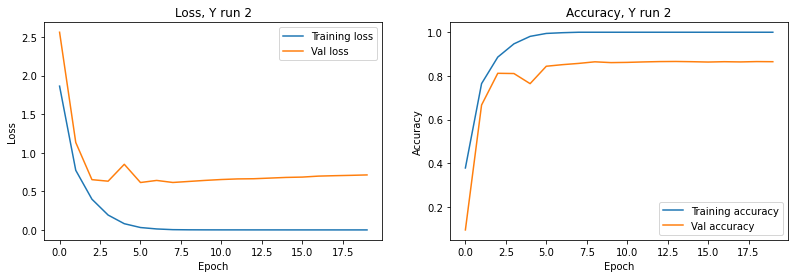

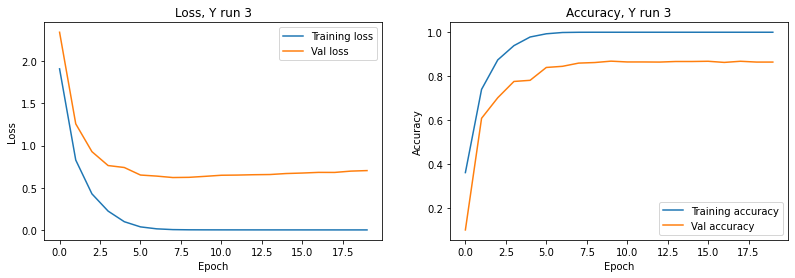

In [36]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 


    history = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
    plots(history,'Y run '+str(i))
    i += 1

#### Dropout 0,5

##### **First 2 layers**

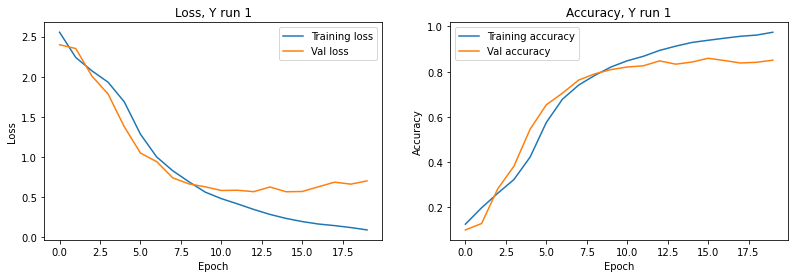

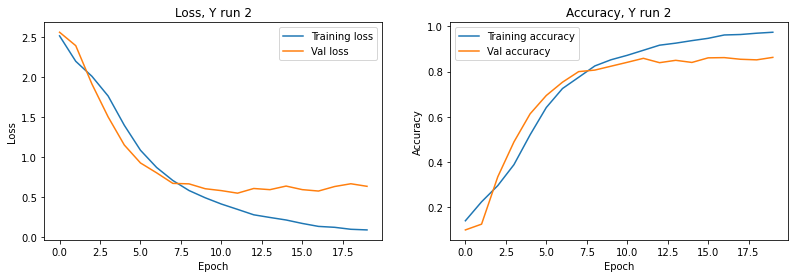

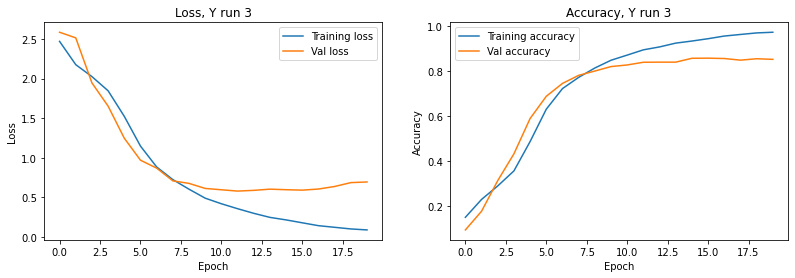

In [45]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 


    history = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
    plots(history,'Y run '+str(i))
    i += 1

##### **Last 2 layers**

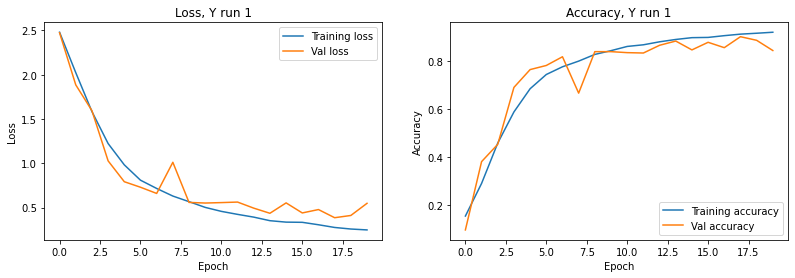

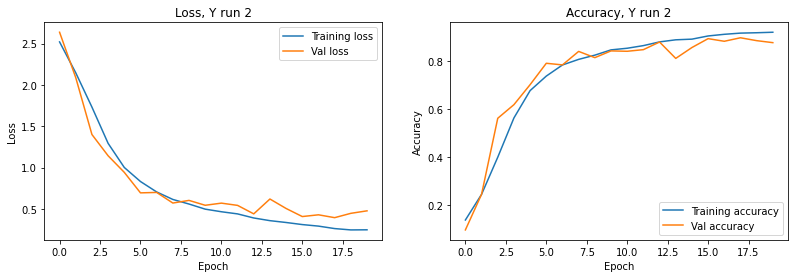

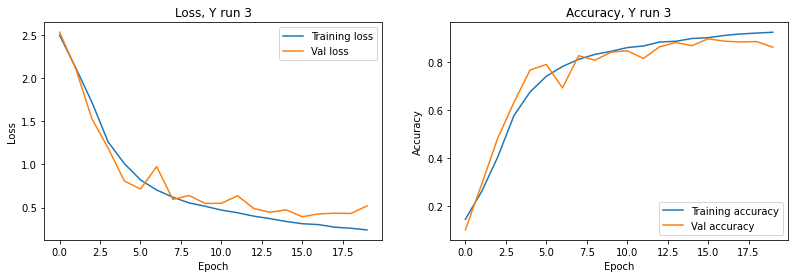

In [44]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 


    history = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
    plots(history,'Y run '+str(i))
    i += 1

##### **All layers**

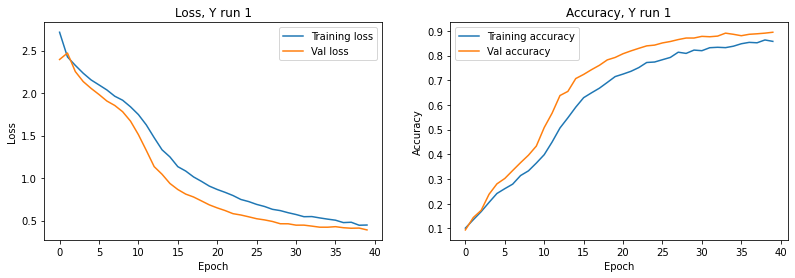

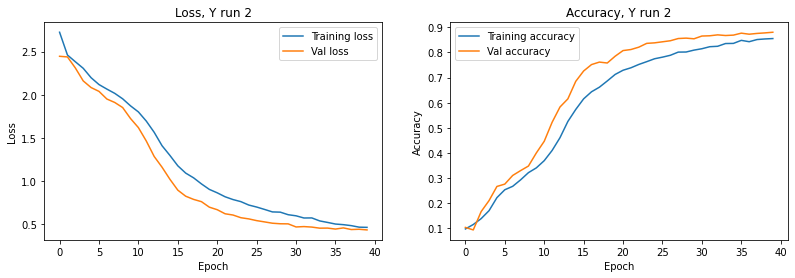

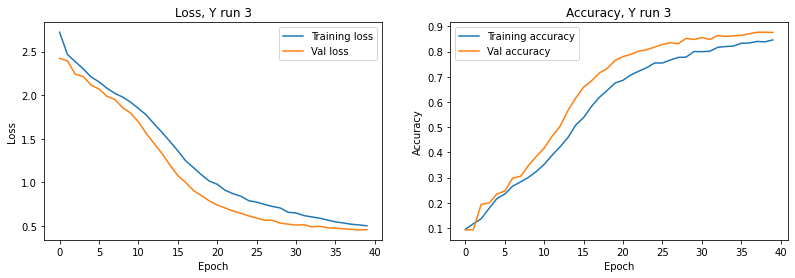

In [51]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 


    history = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=40, verbose=0)
    plots(history,'Y run '+str(i))
    i += 1

#### Earlystopping on optimized model

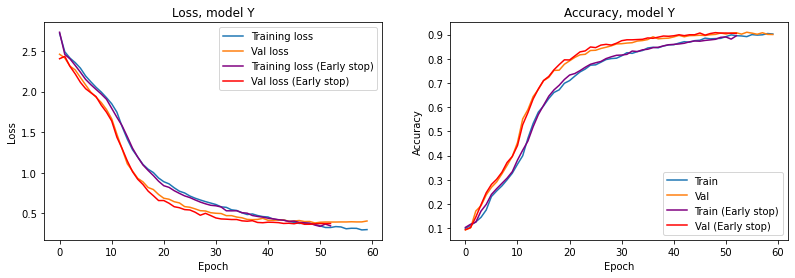

In [65]:
### with early stop
model = tf.keras.models.Sequential([
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    ) 

history_stop = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=60, verbose=0,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))

  
#### Without early stop

model = tf.keras.models.Sequential([
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    ) 

history = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=60, verbose=0)

########
### Plot with and without early stop
########

fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label='Training loss')
ax.plot(history.history['val_loss'], label = 'Val loss')
ax.plot(history_stop.history['loss'], 'purple', label = 'Training loss (Early stop)')
ax.plot(history_stop.history['val_loss'], 'red', label = 'Val loss (Early stop)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, model Y')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['accuracy'], label='Train')
ax.plot(history.history['val_accuracy'], label = 'Val')
ax.plot(history_stop.history['accuracy'], 'purple', label = 'Train (Early stop)')
ax.plot(history_stop.history['val_accuracy'], 'red', label = 'Val (Early stop)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, model Y')

plt.show()


#### Performance on test data

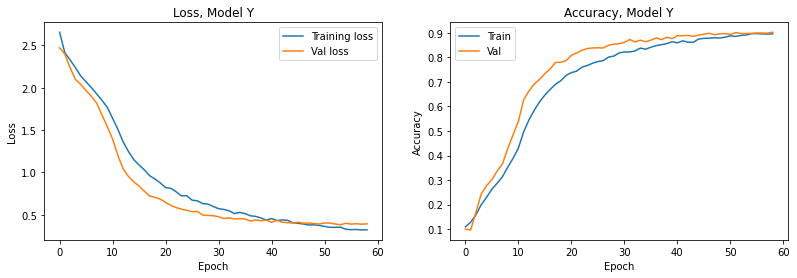

In [92]:
### with early stop
### with early stop
model = tf.keras.models.Sequential([
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    ) 

history = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=60, verbose=0,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))

fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label='Training loss')
ax.plot(history.history['val_loss'], label = 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, Model Y')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['accuracy'], label='Train')
ax.plot(history.history['val_accuracy'], label = 'Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, Model Y')

plt.show()


In [93]:
model.evaluate(x_test, Y_test, batch_size = len(Y_test))

1/1 [==============================] - 0s 156ms/step - loss: 0.4013 - accuracy: 0.8975


[0.4013197422027588, 0.8974999785423279]

### **ModelD**

#### Batch normalization

##### **-2 first layers**

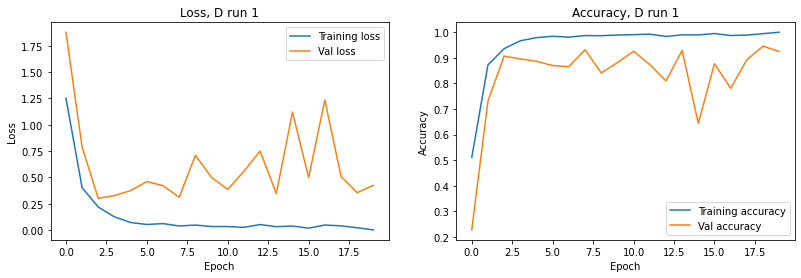

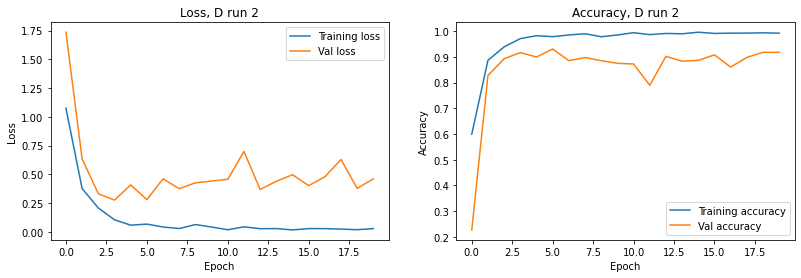

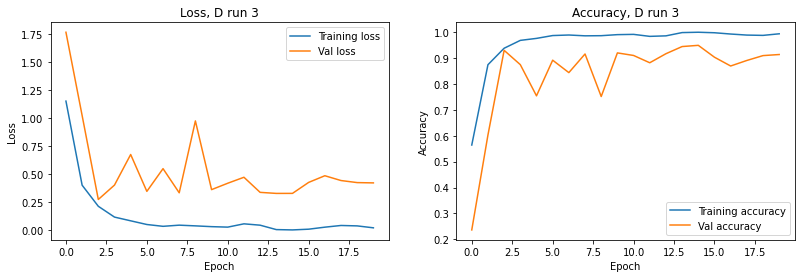

In [25]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer='adam',
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 

    history = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
    plots(history,'D run '+str(i))
    i += 1

##### **-2 last layers**

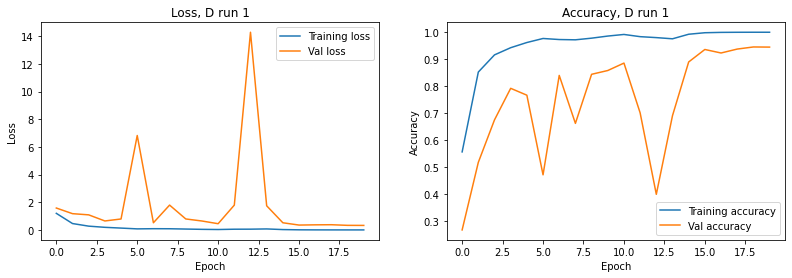

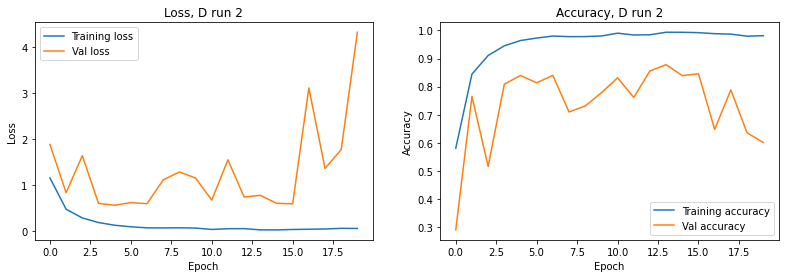

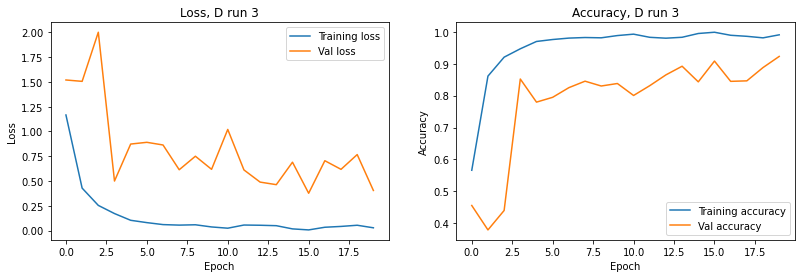

In [26]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer='adam',
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 

    history = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
    plots(history,'D run '+str(i))
    i += 1

##### **-all 4 layers**

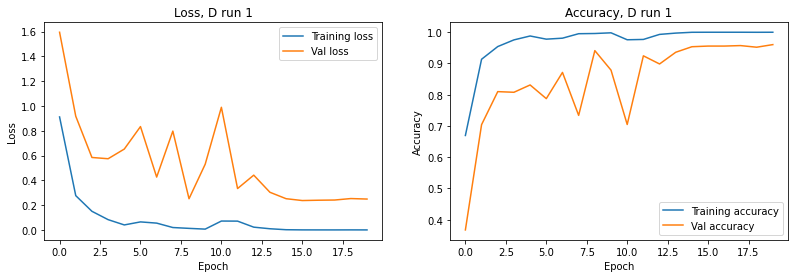

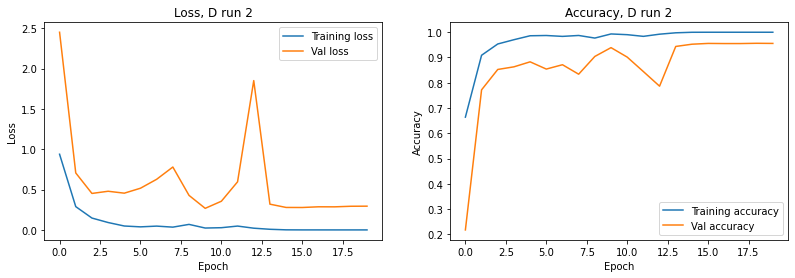

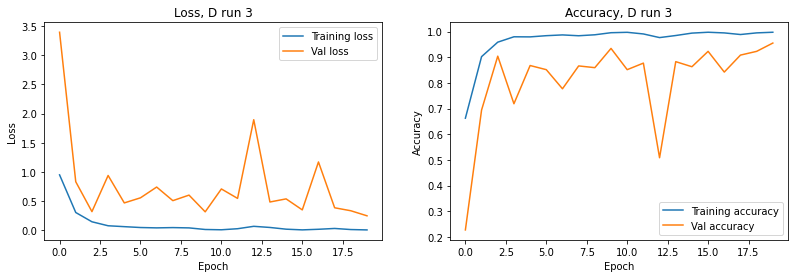

In [27]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer='adam',
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 


    history = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
    plots(history,'D run '+str(i))
    i += 1

#### Learning rates

##### **0.001**

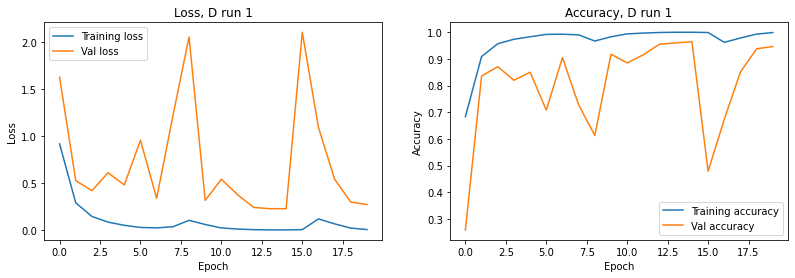

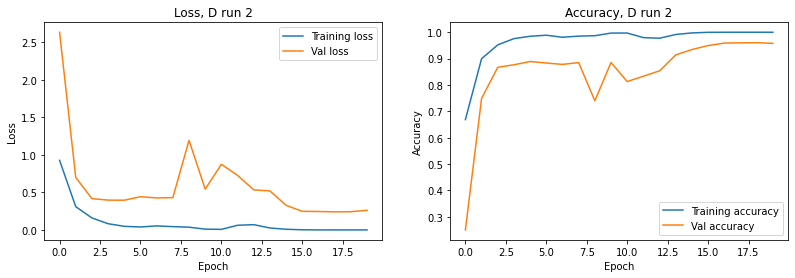

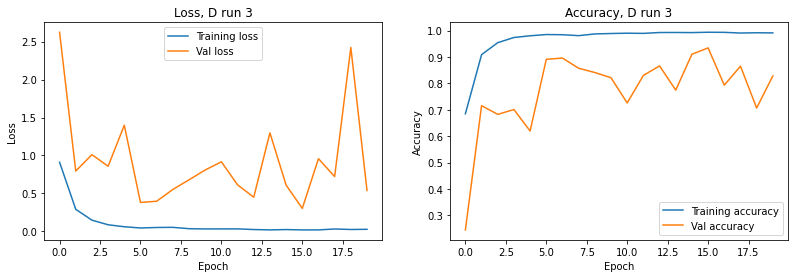

In [37]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 


    history = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
    plots(history,'D run '+str(i))
    i += 1

##### **0.0008**

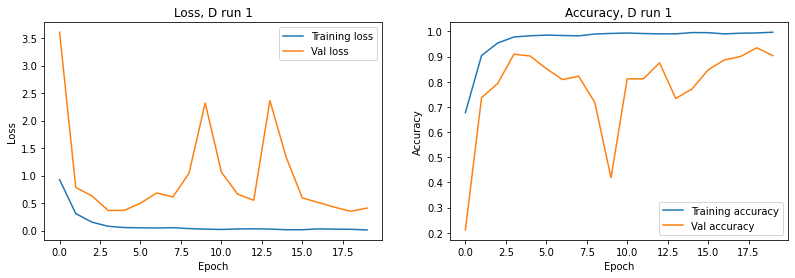

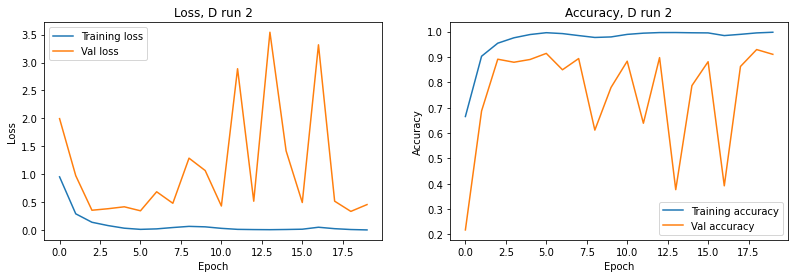

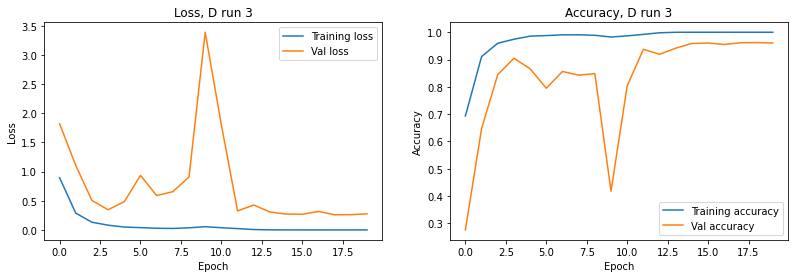

In [38]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 


    history = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
    plots(history,'D run '+str(i))
    i += 1

##### **0.0005**

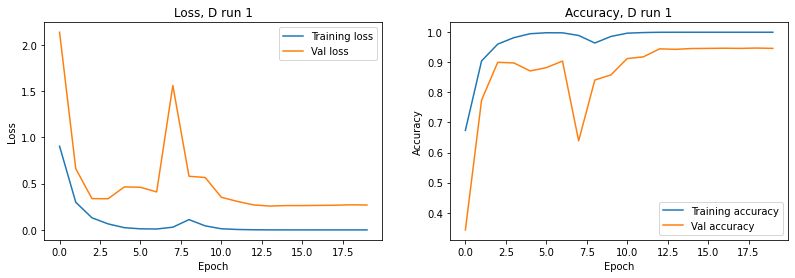

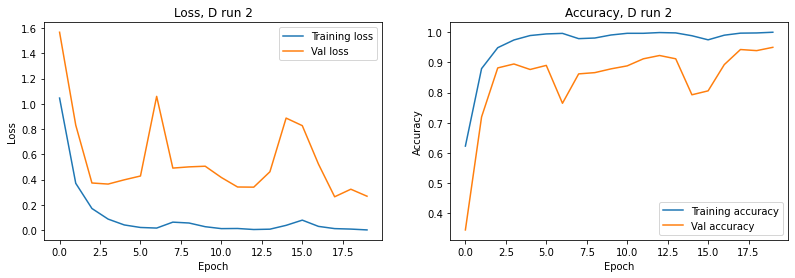

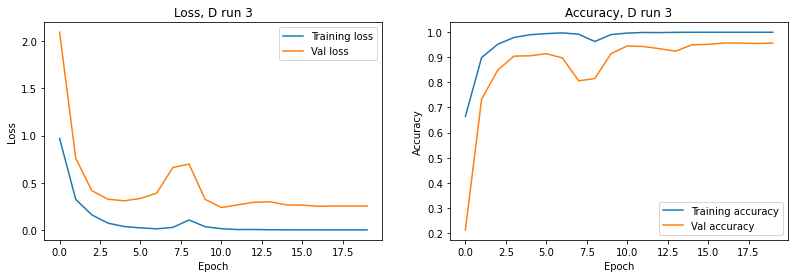

In [39]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 


    history = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
    plots(history,'D run '+str(i))
    i += 1

#### Dropout 0,5

##### **First 2 layers**

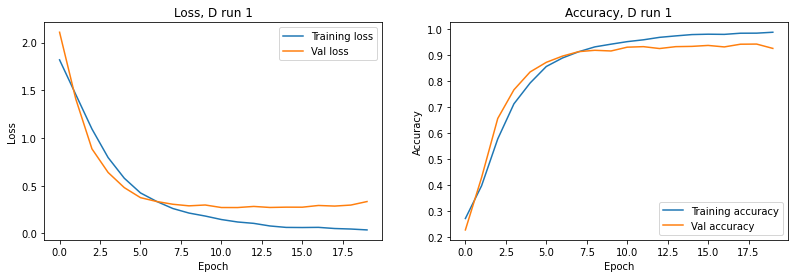

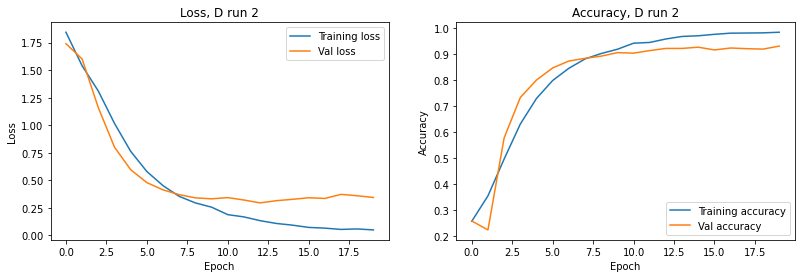

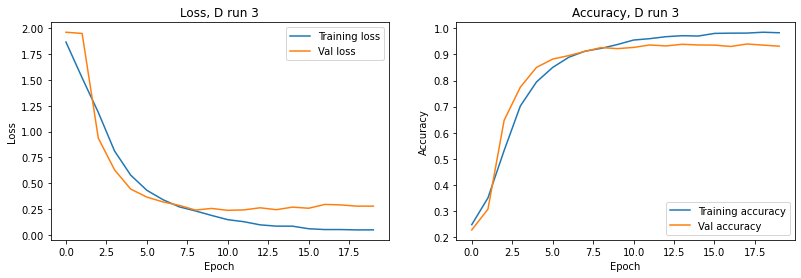

In [42]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 


    history = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
    plots(history,'D run '+str(i))
    i += 1

##### **Last 2 layers**

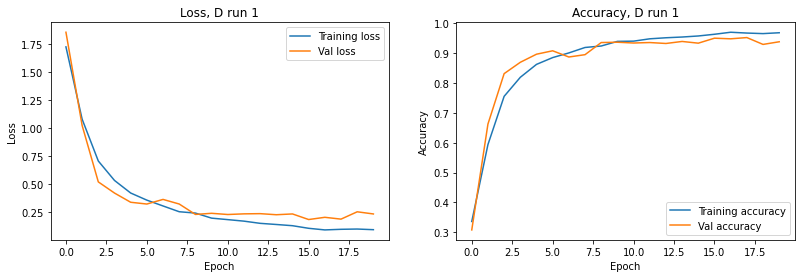

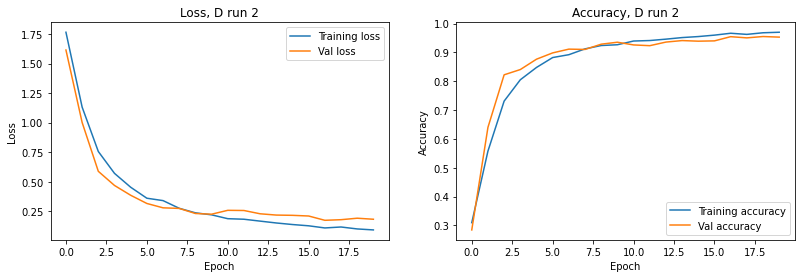

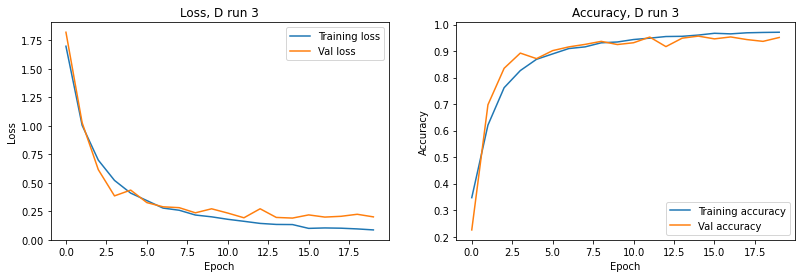

In [41]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 


    history = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
    plots(history,'D run '+str(i))
    i += 1

##### **All layers**

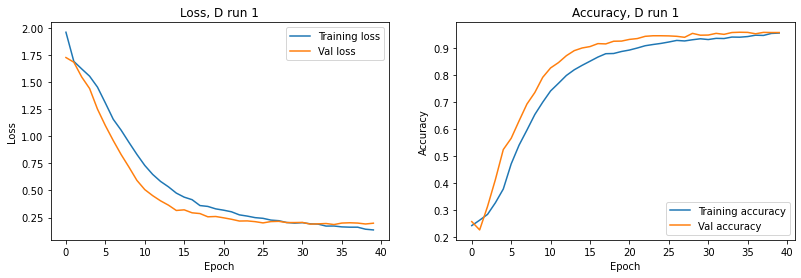

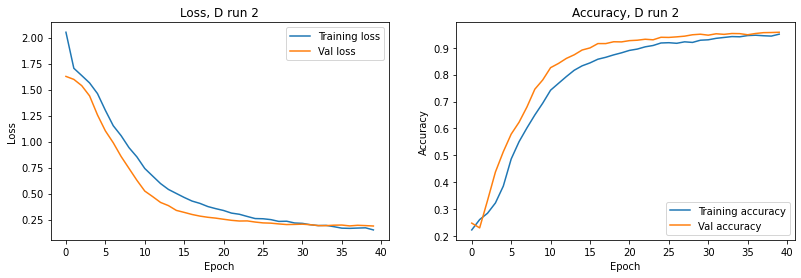

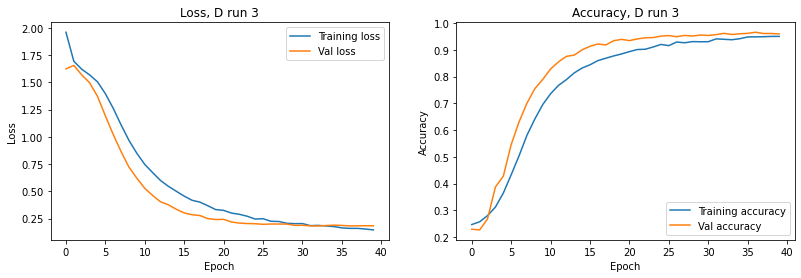

In [52]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 


    history = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=40, verbose=0)
    plots(history,'D run '+str(i))
    i += 1

#### Earlystopping on optimized model

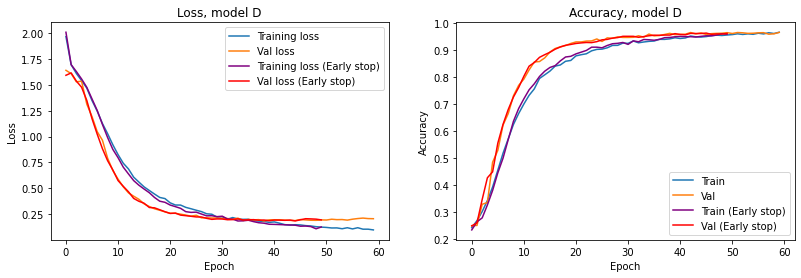

In [60]:
### with early stop
model = tf.keras.models.Sequential([
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    ) 

history_stop = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=60, verbose=0,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))

  
#### Without early stop

model = tf.keras.models.Sequential([
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    ) 

history = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=60, verbose=0)

########
### Plot with and without early stop
########

fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label='Training loss')
ax.plot(history.history['val_loss'], label = 'Val loss')
ax.plot(history_stop.history['loss'], 'purple', label = 'Training loss (Early stop)')
ax.plot(history_stop.history['val_loss'], 'red', label = 'Val loss (Early stop)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, model D')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['accuracy'], label='Train')
ax.plot(history.history['val_accuracy'], label = 'Val')
ax.plot(history_stop.history['accuracy'], 'purple', label = 'Train (Early stop)')
ax.plot(history_stop.history['val_accuracy'], 'red', label = 'Val (Early stop)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, model D')

plt.show()


#### Performance on test data

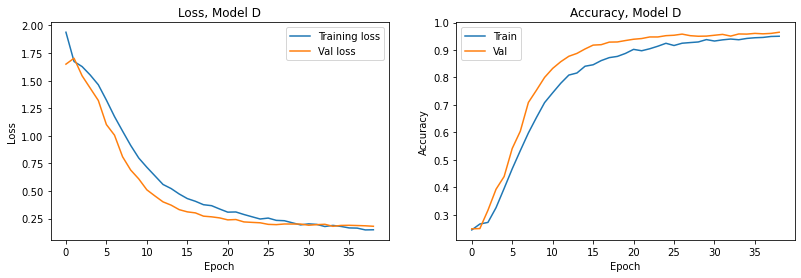

In [94]:
model = tf.keras.models.Sequential([
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    ) 

history = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=60, verbose=0,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))

fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label='Training loss')
ax.plot(history.history['val_loss'], label = 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, Model D')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['accuracy'], label='Train')
ax.plot(history.history['val_accuracy'], label = 'Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, Model D')

plt.show()


In [95]:
model.evaluate(x_test, D_test, batch_size = len(D_test))

1/1 [==============================] - 0s 155ms/step - loss: 0.1806 - accuracy: 0.9496


[0.18058763444423676, 0.9495833516120911]